In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from fastai.vision.all import *
import pathlib

In [4]:
path = pathlib.Path("/kaggle/input/sheep-breed-classification/SheepFaceImages")
Path.BASE_PATH = path
path.ls()

(#4) [Path('Marino'),Path('Suffolk'),Path('Poll Dorset'),Path('White Suffolk')]

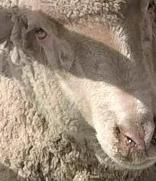

In [15]:
files = get_image_files(path)
img0 = Image.open(files[0])
img0

In [16]:
sheeps = DataBlock(blocks= (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   splitter=RandomSplitter(seed=12)
                   get_y = parent_label,
                   item_tfms = Resize(460),
                   batch_tfms=aug_transforms(size=224, min_scale=0.75, mult=1.5)
                  )
dls = sheeps.dataloaders(path)

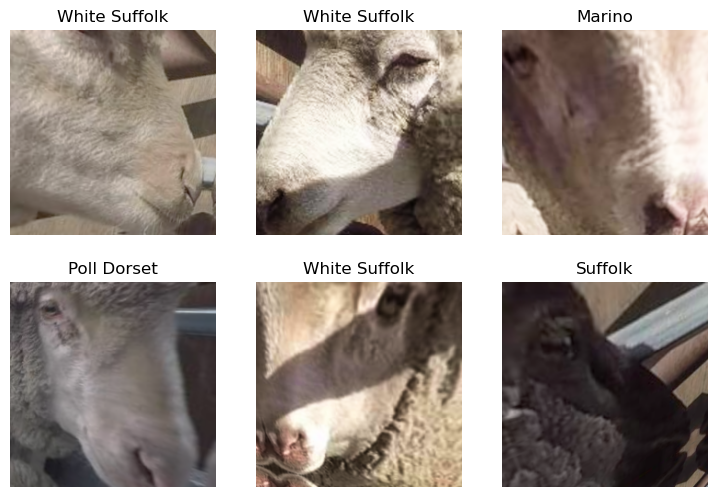

In [17]:
dls.show_batch(nrows=2, ncols=3)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 168MB/s] 


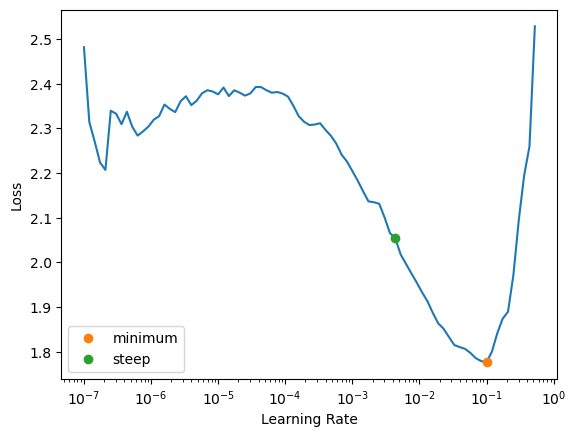

In [19]:
learn = vision_learner(dls, resnet34, metrics=accuracy)
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

In [20]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.00e-02, steepest point: 4.37e-03


In [23]:
learn = vision_learner(dls, resnet34, metrics=accuracy)
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.730035,0.795375,0.279762,00:18
1,1.299086,0.527767,0.205357,00:16
2,1.013091,0.350853,0.130952,00:17


SuggestedLRs(valley=9.120108734350652e-05)

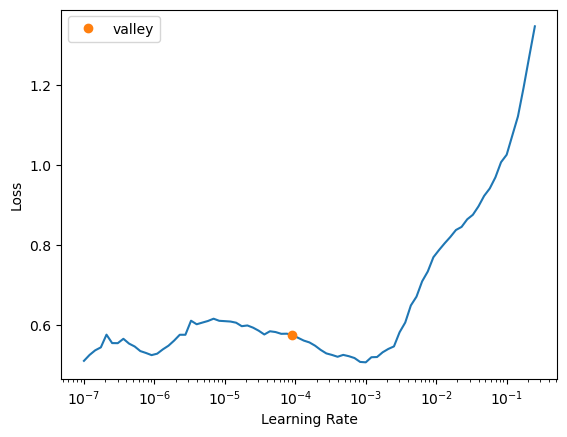

In [24]:
learn.unfreeze()
learn.lr_find()

In [25]:
learn.fit_one_cycle(12, lr_max=slice(1e-4,9e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.649339,0.400336,0.122024,00:17
1,0.540968,0.411244,0.095238,00:18
2,0.534758,0.982149,0.232143,00:17
3,0.455006,0.366500,0.086310,00:18
4,0.370950,0.138601,0.041667,00:18
5,0.309526,0.092330,0.032738,00:17
6,0.245511,0.166559,0.053571,00:18
7,0.198923,0.130713,0.032738,00:17
8,0.164273,0.099608,0.023810,00:18
9,0.133322,0.083680,0.032738,00:17


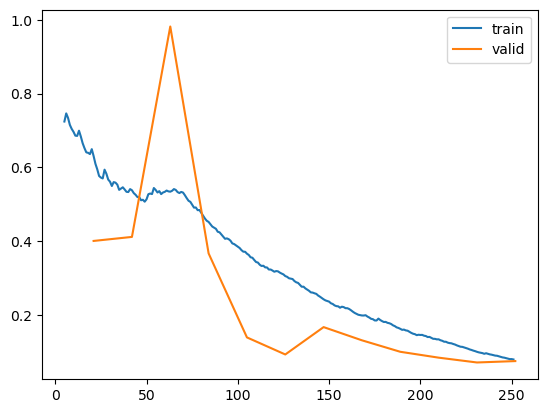

In [26]:
learn.recorder.plot_loss()

## Training a deeper model

SuggestedLRs(minimum=0.005754399299621582, steep=0.0010000000474974513)

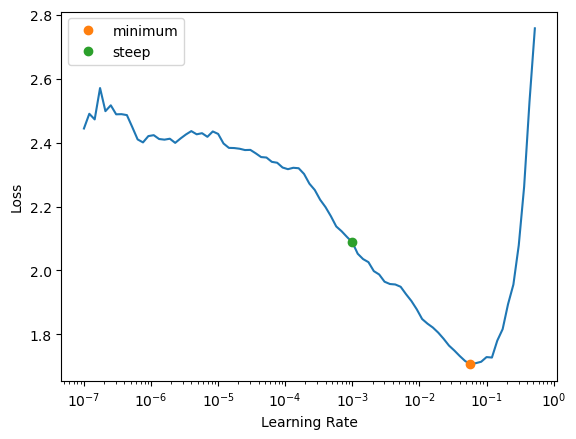

In [31]:
from fastai.callback.fp16 import *
learn = vision_learner(dls, resnet50, metrics=accuracy)
learn.lr_find(suggest_funcs=(minimum, steep))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,time
0,1.658124,0.851920,0.747024,00:19


epoch,train_loss,valid_loss,accuracy,time
0,1.046714,0.565771,0.815476,00:21
1,0.835160,0.386787,0.889881,00:21
2,0.629027,0.374286,0.898810,00:21


SuggestedLRs(valley=7.585775892948732e-05)

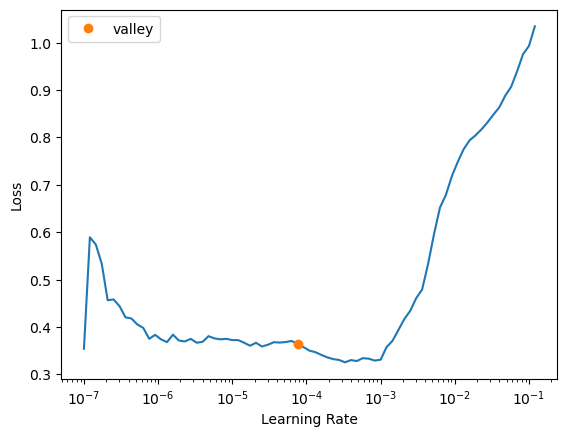

In [32]:
learn = vision_learner(dls, resnet50, metrics=accuracy)
learn.fine_tune(3, 2e-3)
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.fit_one_cycle(12,lr_max=slice(1e-5,2e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.336017,0.336215,0.910714,00:21
1,0.357224,0.425798,0.898810,00:22
2,0.371419,0.369534,0.883929,00:21
3,0.330822,0.274630,0.943452,00:21
4,0.275063,0.227470,0.943452,00:21
5,0.224667,0.127034,0.955357,00:21
6,0.174178,0.160276,0.952381,00:21
7,0.132152,0.104968,0.970238,00:21
8,0.098585,0.080894,0.973214,00:21
